project_root/
├─ input_images/          # put your phone photos / scanned images here
├─ outputs/
│  ├─ corrected/          # perspective-corrected images
│  ├─ enhanced/           # enhanced images
│  ├─ segmented/          # segmentation masks / binarized pages
│  ├─ final/              # final saved/compressed outputs
│  └─ metrics.csv         # PSNR / SSIM results
└─ smart_doc_restoration.py


# smart_doc_restoration.py
"""
Smart Document Restoration & Digitization System

Pipeline per image:
1. Load image
2. Resize (if very large)
3. Detect document edges (Canny + contours / Hough fallback)
4. Perspective correction (four-point transform)
5. Denoise (median + non-local means)
6. Contrast / illumination correction (CLAHE on L channel or contrast stretching)
7. Unsharp mask for sharpening
8. Segmentation (adaptive threshold + morphology) -> text mask
9. Feature extraction (Canny edges, contours info)
10. Save compressed outputs (JPEG quality control) and metrics (PSNR, SSIM)
"""

In [16]:
## Dependency imports

import os
import cv2
import numpy as np
from skimage import restoration, metrics, img_as_ubyte
from skimage.restoration import richardson_lucy
from tqdm import tqdm
import csv
import matplotlib.pyplot as plt

In [17]:
%%script echo skipping
# ---------- Utility functions ----------

def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_image(path, max_dim=2000):
    img = cv2.imdecode(np.fromfile(path, dtype=np.uint8), cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Cannot read image {path}")
    h, w = img.shape[:2]
    scale = 1.0
    if max(h, w) > max_dim:
        scale = max_dim / max(h, w)
        img = cv2.resize(img, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)
    return img

def save_image(path, img, jpeg_quality=90, png_compression=3):
    ext = os.path.splitext(path)[1].lower()
    # handle unicode paths on Windows by using imencode + tofile
    if ext in ['.jpg', '.jpeg']:
        encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), jpeg_quality]
        _, encimg = cv2.imencode(ext, img, encode_param)
        encimg.tofile(path)
    elif ext == '.png':
        encode_param = [int(cv2.IMWRITE_PNG_COMPRESSION), png_compression]
        _, encimg = cv2.imencode(ext, img, encode_param)
        encimg.tofile(path)
    else:
        _, encimg = cv2.imencode('.png', img)
        encimg.tofile(path)

skipping


In [18]:
%%script echo skipping
# ---------- Geometric transforms & detection ----------

def detect_document_contour(img_gray, debug=False):
    # Canny edge detection and find largest 4-point contour
    blurred = cv2.GaussianBlur(img_gray, (5,5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    # find contours
    cnts, _ = cv2.findContours(edges.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:10]
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            pts = approx.reshape(4, 2)
            return order_points(pts)
    # fallback: use Hough lines to estimate edges (coarse)
    if debug:
        print("No 4-point contour found, will fallback to image bounds.")
    h, w = img_gray.shape
    return np.array([[0,0],[w-1,0],[w-1,h-1],[0,h-1]], dtype='float32')

def order_points(pts):
    # Order points: top-left, top-right, bottom-right, bottom-left
    rect = np.zeros((4,2), dtype='float32')
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def four_point_transform_color(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

skipping


In [19]:
%%script echo skipping
# ---------- Restoration & Enhancement ----------

def denoise_image(img):
    # Convert to YCrCb and denoise luminance, or operate on BGR directly.
    # Use median to remove salt-and-pepper, then non-local means for texture-preserving denoise
    den = cv2.medianBlur(img, 3)
    den = cv2.fastNlMeansDenoisingColored(den, None, h=10, hColor=10, templateWindowSize=7, searchWindowSize=21)
    return den

def deblur_richardson_lucy_gray(img_gray, psf=None, iterations=20):
    # If psf not provided, approximate a small gaussian psf
    if psf is None:
        # small gaussian PSF
        size = 5
        x = cv2.getGaussianKernel(size, 1)
        psf = np.outer(x, x)
    imgf = img_gray.astype(np.float64) / 255.0
    deconv = richardson_lucy(imgf, psf, iterations=iterations)
    deconv_u8 = np.clip(deconv * 255, 0, 255).astype(np.uint8)
    return deconv_u8

def apply_clahe_color(img):
    # Convert to LAB and apply CLAHE to L channel
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    res = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return res

def contrast_stretch(img):
    # simple contrast stretching on each channel
    out = np.zeros_like(img)
    for c in range(3):
        ch = img[:,:,c]
        p2, p98 = np.percentile(ch, (2,98))
        out[:,:,c] = cv2.normalize(ch, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        # alternative: linear stretching
        out[:,:,c] = np.clip((ch - p2) * (255.0/(p98 - p2 + 1e-8)), 0, 255).astype(np.uint8)
    return out

def unsharp_mask(img, radius=1, amount=1.0):
    blur = cv2.GaussianBlur(img, (0,0), radius)
    sharp = cv2.addWeighted(img, 1.0 + amount, blur, -amount, 0)
    return sharp

skipping


In [20]:
%%script echo skipping
# ---------- Segmentation & Morphology ----------

def segment_text(img_gray):
    # Adaptive threshold (sauvola/gaussian-like via OpenCV) + morphological clean-up
    th = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY, 25, 10)
    # invert so text is white
    th = 255 - th
    # morphological opening to remove small blobs
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    clean = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel, iterations=1)
    # fill small holes
    clean = cv2.morphologyEx(clean, cv2.MORPH_CLOSE, kernel, iterations=1)
    # final invert to make text dark on light bg
    final = 255 - clean
    return final

skipping


In [21]:
%%script echo skipping
# ---------- Evaluation metrics ----------

def compute_metrics(ref_gray, proc_gray):
    # assuming same shape
    ref = ref_gray.astype(np.float32) / 255.0
    proc = proc_gray.astype(np.float32) / 255.0
    try:
        psnr_v = metrics.peak_signal_noise_ratio(ref, proc, data_range=1.0)
        ssim_v = metrics.structure_similarity(ref, proc, data_range=1.0)
    except Exception:
        psnr_v, ssim_v = None, None
    return psnr_v, ssim_v

skipping


In [22]:
%%script echo skipping
def extract_features(img):
    """
    Extract simple features for reporting and comparison.
    Includes edges, gradients, and texture energy.
    """

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Edge map (Canny)
    edges = cv2.Canny(gray, 100, 200)

    # Sobel gradients
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

    # Texture: Laplacian variance
    lap_var = cv2.Laplacian(gray, cv2.CV_64F).var()

    return {
        "edges": edges,
        "sobel_x": sobel_x,
        "sobel_y": sobel_y,
        "laplacian_variance": float(lap_var)
    }
def extract_features(img):
    """
    Extract simple features for reporting and comparison.
    Includes edges, gradients, and texture energy.
    """

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Edge map (Canny)
    edges = cv2.Canny(gray, 100, 200)

    # Sobel gradients
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

    # Texture: Laplacian variance
    lap_var = cv2.Laplacian(gray, cv2.CV_64F).var()

    return {
        "edges": edges,
        "sobel_x": sobel_x,
        "sobel_y": sobel_y,
        "laplacian_variance": float(lap_var)
    }


skipping


In [23]:
%%script echo skipping
# ---------- Main pipeline ----------

def process_image(path_in, out_dirs, opts):
    img_orig = load_image(path_in, max_dim=opts.get('max_dim', 2000))
    basename = os.path.splitext(os.path.basename(path_in))[0]

    # make grayscale for detection & segmentation tasks
    img_gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)

    # 1) detect document contour
    pts = detect_document_contour(img_gray)
    warped = four_point_transform_color(img_orig, pts)
    save_image(os.path.join(out_dirs['corrected'], f"{basename}_corrected.png"), warped)

    # 2) denoise
    den = denoise_image(warped)
    save_image(os.path.join(out_dirs['enhanced'], f"{basename}_denoised.png"), den)

    # 3) color & illumination correction
    clahe = apply_clahe_color(den)
    stretched = contrast_stretch(clahe)
    sharpen = unsharp_mask(stretched, radius=1, amount=0.8)
    save_image(os.path.join(out_dirs['enhanced'], f"{basename}_enhanced.png"), sharpen)

    # 4) (optional) deblur grayscale using RL
    gray_sharp = cv2.cvtColor(sharpen, cv2.COLOR_BGR2GRAY)
    if opts.get('do_deblur', False):
        deblurred = deblur_richardson_lucy_gray(gray_sharp, iterations=15)
        # convert back to 3-channel for further steps (just replicate)
        deblur_3c = cv2.cvtColor(deblurred, cv2.COLOR_GRAY2BGR)
        save_image(os.path.join(out_dirs['enhanced'], f"{basename}_deblurred.png"), deblur_3c)
        proc_for_seg = deblurred
    else:
        proc_for_seg = gray_sharp

    # 5) segmentation (binarize)
    seg = segment_text(proc_for_seg)
    save_image(os.path.join(out_dirs['segmented'], f"{basename}_seg.png"), seg)

    # 6) feature extraction
    edges, cnts, lines = extract_features(proc_for_seg)
    # overlay edges on original for debugging view
    overlay = warped.copy()
    overlay[edges>0] = [0,0,255]
    save_image(os.path.join(out_dirs['enhanced'], f"{basename}_edges_overlay.png"), overlay)

    # 7) final produce a "clean scan" by combining sharpened image and segmentation (optional)
    # Create a clean white background and place dark text from segmentation
    clean_bg = 255 * np.ones_like(proc_for_seg)
    # Where seg is dark (text), copy from sharpened grayscale
    text_mask = (seg < 128).astype(np.uint8)
    final_scan_gray = np.where(text_mask==1, proc_for_seg, clean_bg).astype(np.uint8)
    final_scan_bgr = cv2.cvtColor(final_scan_gray, cv2.COLOR_GRAY2BGR)
    save_image(os.path.join(out_dirs['final'], f"{basename}_final.png"), final_scan_bgr, jpeg_quality=95)

    # 8) compressed versions
    save_image(os.path.join(out_dirs['final'], f"{basename}_final_q80.jpg"), final_scan_bgr, jpeg_quality=80)
    save_image(os.path.join(out_dirs['final'], f"{basename}_final_q60.jpg"), final_scan_bgr, jpeg_quality=60)
    save_image(os.path.join(out_dirs['final'], f"{basename}_final_lossless.png"), final_scan_bgr, png_compression=0)

    # 9) metrics
    # Reference for comparison could be the corrected grayscale (or the original grayscale resized)
    ref_gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    psnr_v, ssim_v = compute_metrics(ref_gray, final_scan_gray)
    return {
        'basename': basename,
        'psnr': psnr_v,
        'ssim': ssim_v
    }

def main_process(input_folder='input_images', output_root='outputs', opts=None):
    if opts is None:
        opts = {}
    # Setup directories
    out_dirs = {
        'corrected': os.path.join(output_root, 'corrected'),
        'enhanced': os.path.join(output_root, 'enhanced'),
        'segmented': os.path.join(output_root, 'segmented'),
        'final': os.path.join(output_root, 'final'),
    }
    for d in out_dirs.values():
        ensure_dir(d)

    # process each file in input folder
    results = []
    files = [os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.lower().endswith(('.png','.jpg','.jpeg','.tif','.bmp'))]
    for f in tqdm(files, desc="Processing images"):
        try:
            r = process_image(f, out_dirs, opts)
            results.append(r)
        except Exception as e:
            print(f"Failed {f}: {e}")

    # save metrics CSV
    csv_path = os.path.join(output_root, 'metrics.csv')
    with open(csv_path, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=['basename','psnr','ssim'])
        writer.writeheader()
        for r in results:
            writer.writerow(r)
    print(f"Done. Metrics saved to {csv_path}")

if __name__ == '__main__':
    # Example usage: enable deblurring if you expect motion blur
    options = {
        'max_dim': 2000,
        'do_deblur': False
    }
    main_process(input_folder='input_images', output_root='outputs', opts=options)

skipping


In [24]:
%%script echo skipping
# ---------- Visualization utility ----------#
def show_comparison(images, titles, figsize=(18, 4)):
    """
    Display images side-by-side for comparison.
    
    Args:
        images: list of image arrays
        titles: list of strings for titles
        figsize: tuple for figure size
    """
    n = len(images)
    plt.figure(figsize=figsize)

    for i in range(n):
        plt.subplot(1, n, i + 1)
        if len(images[i].shape) == 2:  # grayscale
            plt.imshow(images[i], cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))  # BGR→RGB
        plt.title(titles[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

skipping


Modular coding

In [ ]:
## Module 1: Image Enhancement Pipeline

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# -------------------------------
# Adjustable Parameters
# -------------------------------
use_clahe = True
clahe_clip = 4.0
clahe_tile = (8,8)

use_contrast_stretch = True
stretch_percentiles = (2, 98)  # low and high percentiles

use_unsharp_mask = True
unsharp_radius = 1
unsharp_amount = 1.2

# -------------------------------
# Helper Function: Show Comparison
# -------------------------------
def show_comparison(images, titles, figsize=(12,4)):
    n = len(images)
    plt.figure(figsize=figsize)
    for i in range(n):
        plt.subplot(1, n, i+1)
        img = images[i]
        if len(img.shape) == 2:  # grayscale
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# -------------------------------
# Enhancement Functions
# -------------------------------
def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=clahe_tile)
    l = clahe.apply(l)
    lab = cv2.merge([l, a, b])
    return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

def contrast_stretch(img, percentiles=(2,98)):
    in_min, in_max = np.percentile(img, percentiles)
    out = np.clip((img - in_min) * 255 / (in_max - in_min), 0, 255).astype(np.uint8)
    return out

def unsharp_mask(img, radius=1, amount=0.8):
    blurred = cv2.GaussianBlur(img, (radius*2+1, radius*2+1), 0)
    sharpened = cv2.addWeighted(img, 1+amount, blurred, -amount, 0)
    return sharpened

# -------------------------------
# Load Image
# -------------------------------
input_path = "input_images/shadow.jpg"  # Example
img = cv2.imread(input_path)

if img is None:
    raise FileNotFoundError(f"Cannot read image {input_path}")

# -------------------------------
# Apply Enhancements
# -------------------------------
enhanced = img.copy()

if use_clahe:
    enhanced = apply_clahe(enhanced)

if use_contrast_stretch:
    enhanced = contrast_stretch(enhanced, stretch_percentiles)

if use_unsharp_mask:
    enhanced = unsharp_mask(enhanced, unsharp_radius, unsharp_amount)

# -------------------------------
# Show Before/After
# -------------------------------
show_comparison([img, enhanced], ["Original", "Enhanced"])


usage: ipykernel_launcher.py [-h] --input INPUT [--output OUTPUT] [--show]
ipykernel_launcher.py: error: the following arguments are required: --input


SystemExit: 2

c:\Users\User\Downloads\All Study Shits\Each Sem Material\Y4S1\BERR4723 Digital Image Processing\Assignment\venv\Lib\site-packages\IPython\core\interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


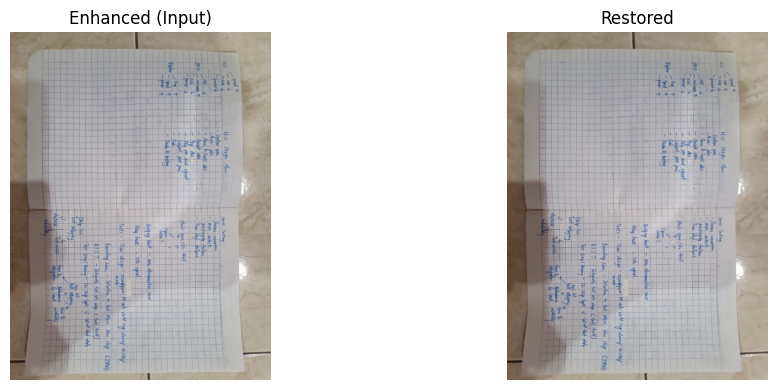

In [40]:
# Module 2: Image Restoration Pipeline

import cv2
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Adjustable Parameters
# -------------------------------
# Median Filter
use_median = True
median_ksize = 3  # must be odd: 3,5,7...

# Non-Local Means Denoising
use_nlm = True
nlm_h = 10
nlm_hColor = 10
template_window = 7
search_window = 21

# Optional: Deblurring (Wiener-like sharpening)
use_deblur = False
deblur_kernel = np.array([[0, -1, 0],
                          [-1, 5,-1],
                          [0, -1, 0]])

# -------------------------------
# Helper Function: Show Comparison
# -------------------------------
def show_comparison(images, titles, figsize=(12,4)):
    n = len(images)
    plt.figure(figsize=figsize)
    for i in range(n):
        plt.subplot(1, n, i+1)
        img = images[i]
        if len(img.shape) == 2:  # grayscale
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# -------------------------------
# Restoration Functions
# -------------------------------
def median_denoise(img, ksize=3):
    return cv2.medianBlur(img, ksize)

def nlm_denoise(img, h=10, hColor=10, templateWindow=7, searchWindow=21):
    return cv2.fastNlMeansDenoisingColored(img, None, h, hColor, templateWindow, searchWindow)

def deblur_image(img, kernel):
    return cv2.filter2D(img, -1, kernel)

# -------------------------------
# Input: Use output from Module 1
# -------------------------------

input_path = "input_images/shadow.jpg"  # Example
img = cv2.imread(input_path)
input_img = img  # from Module 1
restored = input_img.copy()

if use_median:
    restored = median_denoise(restored, median_ksize)

if use_nlm:
    restored = nlm_denoise(restored, nlm_h, nlm_hColor, template_window, search_window)

if use_deblur:
    restored = deblur_image(restored, deblur_kernel)

# -------------------------------
# Show Before/After
# -------------------------------
show_comparison([input_img, restored], ["Enhanced (Input)", "Restored"])


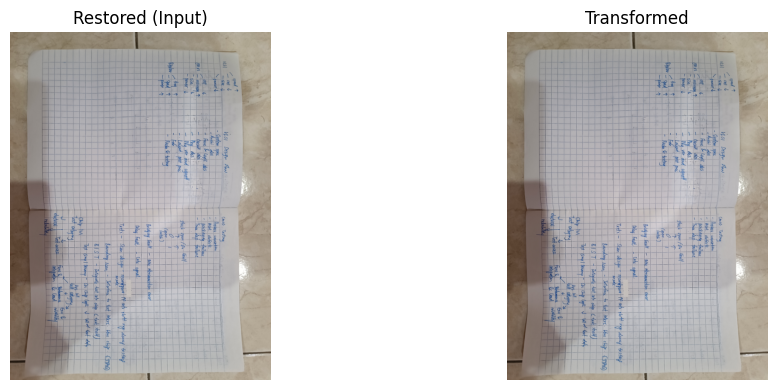

In [41]:
# Module 3: Geometric Transformations & Detection

import cv2
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Adjustable Parameters
# -------------------------------
# Rotation
use_rotation = True
rotation_angle = 0  # degrees, positive = counter-clockwise

# Scaling
use_scaling = True
scale_factor = 1.0  # e.g., 0.5 for half size, 2.0 for double size

# Translation
use_translation = True
translate_x = 0  # pixels
translate_y = 0  # pixels

# Perspective Correction / Deskew
use_perspective = False
# For automatic document-like detection: threshold + contour approx
blur_kernel = (5,5)
canny_thresh1 = 50
canny_thresh2 = 150
approx_epsilon = 0.02

# -------------------------------
# Helper Function: Show Comparison
# -------------------------------
def show_comparison(images, titles, figsize=(12,4)):
    n = len(images)
    plt.figure(figsize=figsize)
    for i in range(n):
        plt.subplot(1, n, i+1)
        img = images[i]
        if len(img.shape) == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# -------------------------------
# Transformation Functions
# -------------------------------
def rotate_image(img, angle):
    (h, w) = img.shape[:2]
    center = (w//2, h//2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(img, M, (w, h))

def scale_image(img, factor):
    h, w = img.shape[:2]
    return cv2.resize(img, (int(w*factor), int(h*factor)), interpolation=cv2.INTER_LINEAR)

def translate_image(img, tx, ty):
    M = np.float32([[1,0,tx],[0,1,ty]])
    h, w = img.shape[:2]
    return cv2.warpAffine(img, M, (w, h))

def auto_perspective_correction(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, blur_kernel, 0)
    edges = cv2.Canny(blur, canny_thresh1, canny_thresh2)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return img  # no contour found
    
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    for c in contours:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, approx_epsilon * peri, True)
        if len(approx) == 4:
            pts = approx.reshape(4,2)
            # Order points: top-left, top-right, bottom-right, bottom-left
            s = pts.sum(axis=1)
            diff = np.diff(pts, axis=1)
            rect = np.array([
                pts[np.argmin(s)],
                pts[np.argmin(diff)],
                pts[np.argmax(s)],
                pts[np.argmax(diff)]
            ], dtype="float32")
            
            (tl, tr, br, bl) = rect
            widthA = np.linalg.norm(br-bl)
            widthB = np.linalg.norm(tr-tl)
            maxWidth = max(int(widthA), int(widthB))
            heightA = np.linalg.norm(tr-br)
            heightB = np.linalg.norm(tl-bl)
            maxHeight = max(int(heightA), int(heightB))
            
            dst = np.array([[0,0],[maxWidth-1,0],[maxWidth-1,maxHeight-1],[0,maxHeight-1]], dtype="float32")
            M = cv2.getPerspectiveTransform(rect, dst)
            warped = cv2.warpPerspective(img, M, (maxWidth, maxHeight))
            return warped
    return img  # fallback

# -------------------------------
# Input: Use output from Module 2
# -------------------------------
input_path = "input_images/shadow.jpg"  # Example
img = cv2.imread(input_path)
input_img = img  # from Module 1
transformed = input_img.copy()

if use_rotation:
    transformed = rotate_image(transformed, rotation_angle)

if use_scaling:
    transformed = scale_image(transformed, scale_factor)

if use_translation:
    transformed = translate_image(transformed, translate_x, translate_y)

if use_perspective:
    transformed = auto_perspective_correction(transformed)

# -------------------------------
# Show Before/After
# -------------------------------
show_comparison([input_img, transformed], ["Restored (Input)", "Transformed"])


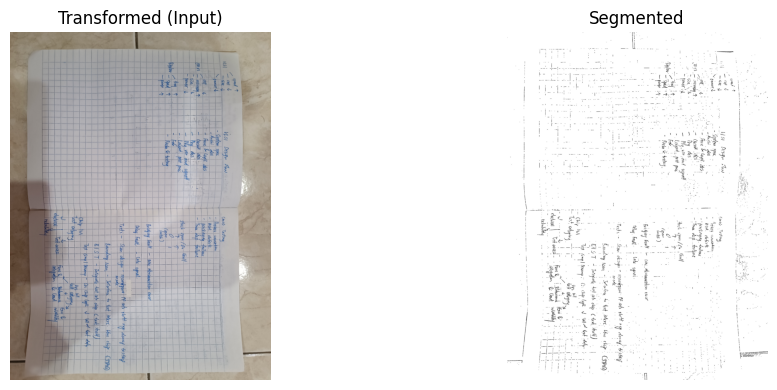

In [42]:
# Module 4: Segmentation & Morphological Operations

import cv2
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Adjustable Parameters
# -------------------------------
# Thresholding
use_global_thresh = False
global_thresh_value = 127

use_adaptive_thresh = True
adaptive_method = cv2.ADAPTIVE_THRESH_GAUSSIAN_C  # or cv2.ADAPTIVE_THRESH_MEAN_C
adaptive_block_size = 15  # must be odd
adaptive_C = 5

# Edge detection
use_canny = True
canny_thresh1 = 50
canny_thresh2 = 150

# Morphological operations
use_morph = True
morph_kernel_size = 3
morph_iterations = 1
morph_operation = cv2.MORPH_CLOSE  # cv2.MORPH_OPEN, cv2.MORPH_CLOSE

# -------------------------------
# Helper Function: Show Comparison
# -------------------------------
def show_comparison(images, titles, figsize=(12,4)):
    n = len(images)
    plt.figure(figsize=figsize)
    for i in range(n):
        plt.subplot(1, n, i+1)
        img = images[i]
        if len(img.shape) == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# -------------------------------
# Segmentation Functions
# -------------------------------
def global_threshold(img, thresh_val=127):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, th = cv2.threshold(gray, thresh_val, 255, cv2.THRESH_BINARY)
    return th

def adaptive_threshold(img, method=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, block_size=15, C=5):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.adaptiveThreshold(gray, 255, method, cv2.THRESH_BINARY, block_size, C)

def edge_detection(img, t1=50, t2=150):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.Canny(gray, t1, t2)

def morphological(img, kernel_size=3, iterations=1, operation=cv2.MORPH_CLOSE):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    return cv2.morphologyEx(img, operation, kernel, iterations=iterations)

# -------------------------------
# Input: Use output from Module 3
# -------------------------------
input_path = "input_images/shadow.jpg"  # Example
img = cv2.imread(input_path)
input_img = img  # from Module 1
segmented = input_img.copy()

# Apply thresholding
if use_global_thresh:
    segmented = global_threshold(segmented, global_thresh_value)
elif use_adaptive_thresh:
    segmented = adaptive_threshold(segmented, adaptive_method, adaptive_block_size, adaptive_C)

# Apply edge detection
if use_canny:
    edges = edge_detection(input_img, canny_thresh1, canny_thresh2)
    # Combine edges with thresholded mask (optional)
    segmented = cv2.bitwise_or(segmented, edges)

# Apply morphology
if use_morph:
    segmented = morphological(segmented, morph_kernel_size, morph_iterations, morph_operation)

# -------------------------------
# Show Before/After
# -------------------------------
show_comparison([input_img, segmented], ["Transformed (Input)", "Segmented"])


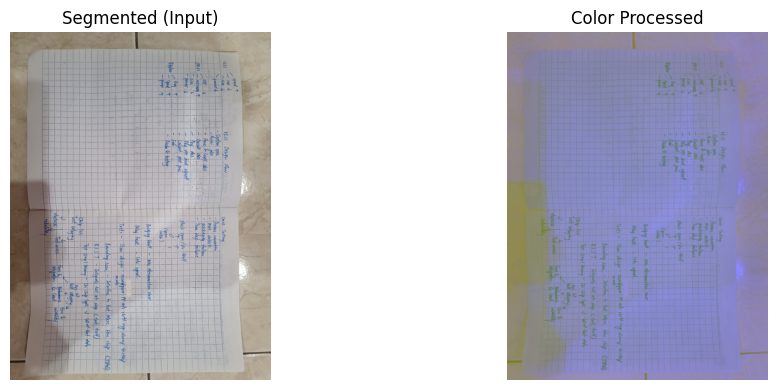

In [43]:
# Module 5: Color Processing & Enhancement

import cv2
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Adjustable Parameters
# -------------------------------
use_color_space_conversion = True
# Options: "HSV", "LAB", "YCrCb"
target_color_space = "LAB"

use_color_enhancement = True
# For LAB, we usually enhance the L channel
clahe_clip = 2.0
clahe_tile = (8,8)

# -------------------------------
# Helper Function: Show Comparison
# -------------------------------
def show_comparison(images, titles, figsize=(12,4)):
    n = len(images)
    plt.figure(figsize=figsize)
    for i in range(n):
        plt.subplot(1, n, i+1)
        img = images[i]
        if len(img.shape) == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# -------------------------------
# Color Processing Functions
# -------------------------------
def convert_color_space(img, space="LAB"):
    if space.upper() == "HSV":
        return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif space.upper() == "LAB":
        return cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    elif space.upper() == "YCrCb":
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    else:
        raise ValueError("Unsupported color space")

def enhance_color_lab(img, clipLimit=2.0, tileGrid=(8,8)):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGrid)
    l = clahe.apply(l)
    lab = cv2.merge([l, a, b])
    return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

# -------------------------------
# Input: Use output from Module 4
# -------------------------------
input_path = "input_images/shadow.jpg"  # Example
img = cv2.imread(input_path)
input_img = img  # from Module 1

if len(input_img.shape) == 2:
    input_img = cv2.cvtColor(input_img, cv2.COLOR_GRAY2BGR)

color_processed = input_img.copy()

if use_color_space_conversion:
    color_processed = convert_color_space(color_processed, target_color_space)
    # Convert back to BGR for visualization
    if target_color_space.upper() == "HSV":
        color_processed = cv2.cvtColor(color_processed, cv2.COLOR_HSV2BGR)
    elif target_color_space.upper() == "YCrCb":
        color_processed = cv2.cvtColor(color_processed, cv2.COLOR_YCrCb2BGR)

if use_color_enhancement:
    color_processed = enhance_color_lab(color_processed, clahe_clip, clahe_tile)

# -------------------------------
# Show Before/After
# -------------------------------
show_comparison([input_img, color_processed], ["Segmented (Input)", "Color Processed"])


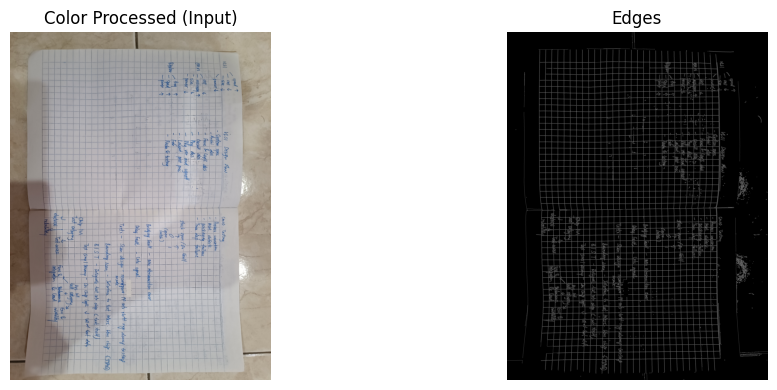

Extracted Sobel Features:
grad_magnitude_mean: 32.6657
grad_magnitude_std: 66.0324
grad_angle_mean: 174.3966
grad_angle_std: 105.9235


In [44]:
# Module 6: Feature Extraction & Reporting

import cv2
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Adjustable Parameters
# -------------------------------
use_canny_edges = True
canny_thresh1 = 50
canny_thresh2 = 150

use_sobel_features = True
sobel_ksize = 3

# -------------------------------
# Helper Function: Show Comparison
# -------------------------------
def show_comparison(images, titles, figsize=(12,4)):
    n = len(images)
    plt.figure(figsize=figsize)
    for i in range(n):
        plt.subplot(1, n, i+1)
        img = images[i]
        if len(img.shape) == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# -------------------------------
# Feature Extraction Functions
# -------------------------------
def extract_edges(img, t1=50, t2=150):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape)==3 else img
    edges = cv2.Canny(gray, t1, t2)
    return edges

def extract_sobel_features(img, ksize=3):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape)==3 else img
    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    magnitude = cv2.magnitude(grad_x, grad_y)
    angle = cv2.phase(grad_x, grad_y, angleInDegrees=True)
    features = {
        'grad_magnitude_mean': np.mean(magnitude),
        'grad_magnitude_std': np.std(magnitude),
        'grad_angle_mean': np.mean(angle),
        'grad_angle_std': np.std(angle)
    }
    return magnitude, angle, features

# -------------------------------
# Input: Use output from Module 5
# -------------------------------
input_path = "input_images/shadow.jpg"  # Example
img = cv2.imread(input_path)
input_img = img  # from Module 1
features = {}

# Edge map
if use_canny_edges:
    edges = extract_edges(input_img, canny_thresh1, canny_thresh2)
    features['edge_map'] = edges

# Sobel gradients
if use_sobel_features:
    magnitude, angle, sobel_feats = extract_sobel_features(input_img, sobel_ksize)
    features.update(sobel_feats)

# -------------------------------
# Display results
# -------------------------------
if 'edge_map' in features:
    show_comparison([input_img, features['edge_map']], ["Color Processed (Input)", "Edges"])

print("Extracted Sobel Features:")
for k, v in features.items():
    if k != 'edge_map':
        print(f"{k}: {v:.4f}")


Saved JPEG (quality=30): outputs/compressed\compressed_jpeg_q30.jpg
Saved JPEG (quality=60): outputs/compressed\compressed_jpeg_q60.jpg
Saved JPEG (quality=90): outputs/compressed\compressed_jpeg_q90.jpg
Saved PNG (compression=0): outputs/compressed\compressed_png_l0.png
Saved PNG (compression=5): outputs/compressed\compressed_png_l5.png
Saved PNG (compression=9): outputs/compressed\compressed_png_l9.png


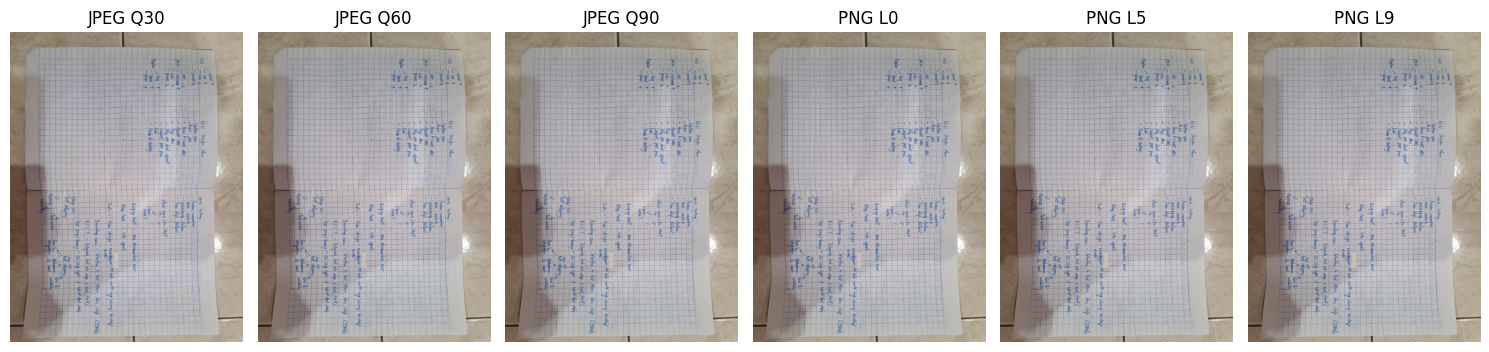

In [45]:
# Module 7: Image Compression & Comparison

import cv2
import os

# -------------------------------
# Adjustable Parameters
# -------------------------------
output_dir = "outputs/compressed"
os.makedirs(output_dir, exist_ok=True)

# JPEG compression quality: 0 (worst) to 100 (best)
jpeg_qualities = [30, 60, 90]

# PNG compression level: 0 (no compression) to 9 (max compression)
png_levels = [0, 5, 9]

# Input: Use output from Module 5 or 6
input_path = "input_images/shadow.jpg"  # Example
img = cv2.imread(input_path)
input_img = img  # from Module 1

# -------------------------------
# JPEG Compression
# -------------------------------
for q in jpeg_qualities:
    output_path = os.path.join(output_dir, f"compressed_jpeg_q{q}.jpg")
    cv2.imwrite(output_path, input_img, [cv2.IMWRITE_JPEG_QUALITY, q])
    print(f"Saved JPEG (quality={q}): {output_path}")

# -------------------------------
# PNG Compression
# -------------------------------
for lvl in png_levels:
    output_path = os.path.join(output_dir, f"compressed_png_l{lvl}.png")
    cv2.imwrite(output_path, input_img, [cv2.IMWRITE_PNG_COMPRESSION, lvl])
    print(f"Saved PNG (compression={lvl}): {output_path}")

# -------------------------------
# Visual Comparison
# -------------------------------
import matplotlib.pyplot as plt

# Load compressed images
compressed_images = []
titles = []

for q in jpeg_qualities:
    path = os.path.join(output_dir, f"compressed_jpeg_q{q}.jpg")
    img = cv2.imread(path)
    compressed_images.append(img)
    titles.append(f"JPEG Q{q}")

for lvl in png_levels:
    path = os.path.join(output_dir, f"compressed_png_l{lvl}.png")
    img = cv2.imread(path)
    compressed_images.append(img)
    titles.append(f"PNG L{lvl}")

# Display side-by-side
plt.figure(figsize=(15,5))
for i, img in enumerate(compressed_images):
    plt.subplot(1, len(compressed_images), i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


Applying preset: NIGHT (Simple global contrast stretch and strong brightening.)


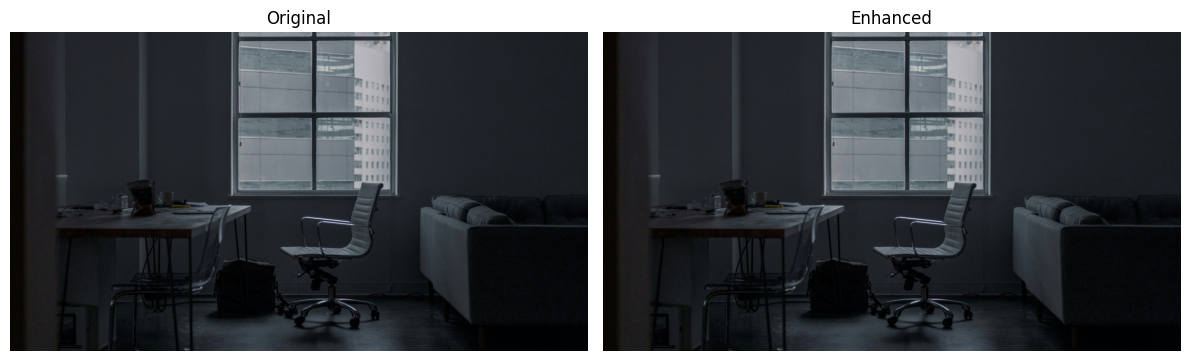

In [70]:
"""
Unified Shadow-Protected Image Enhancement Pipeline
- Integrates: shadow masking, adaptive CLAHE, optional Retinex, adaptive contrast stretching,
  and adaptive unsharp masking.
- General-purpose (works on photos, landscapes, portraits, documents, etc.)

Usage:
    python shadow_protected_enhancement.py --input input_images/shadow.jpg

Adjust parameters in the `CONFIG` dict or via the command-line flags implemented below.
"""
import sys
import cv2
import numpy as np
import argparse
import os
import matplotlib.pyplot as plt


def running_in_notebook():
    return 'ipykernel' in sys.modules

def cli_main():
    if running_in_notebook():
        # --- ORIGINAL CODE ---
        img = cv2.imread("C:\\Users\\User\\Downloads\\All Study Shits\\Each Sem Material\\Y4S1\\BERR4723 Digital Image Processing\\Assignment\\input_images\\LowLight.png") 
        
        # --- ADDED CHECK ---
        if img is None:
            print("ERROR: Failed to load image 'skew, dark patch.jpg'.")
            print("Check if the file exists and the path is correct.")
            return
        # -------------------
        
        enhanced, mask = enhance_image(img)
        show_image_comparison(img, enhanced)
        return
    
# -------------------------------
# 1. CONFIGURATION PRESETS
# -------------------------------
# Note: You need to tune these parameters specifically for your needs.
PRESETS = {
    # Optimized for reading notes: High protection for dark text, focuses on light equalization.
    "DOCUMENT": {
        'shadow_v_threshold': 110,           # High V-threshold to include dark text in the protection mask
        'mask_blur_ksize': 51,
        'use_clahe': False,                  # CLAHE is usually too aggressive for text
        'clahe_clip': 3.0,
        'use_contrast_stretch': True,
        'stretch_percentiles': (5, 98),      # High low-percentile to ignore dark ink
        'use_retinex': True,
        'retinex_sigma': 80,
        'retinex_blend': 0.6,                # Moderate Retinex to lift shadows smoothly
        'use_unsharp': True,
        'unsharp_amount': 0.8,               # Slightly less sharpening
        'final_shadow_blend_strength': 0.7,  # Moderate final blend to remove shadow boundaries
        'mode_info': "Focuses on illumination equalization and text protection."
    },
    
    # Optimized for very dark scenes: Aggressive brightening and local contrast.
    "NIGHT": {
        'shadow_v_threshold': 80,            # Low threshold, targeting only deep shadows
        'mask_blur_ksize': 51,
        'use_clahe': False,
        'clahe_clip': 8.0,                   # Aggressive CLAHE clip to boost contrast in dark areas
        'use_contrast_stretch': True,
        'stretch_percentiles': (1, 99),      # Wide stretch for maximum dynamic range
        'use_retinex': False,
        'retinex_sigma': 150,                # Larger sigma for broader illumination correction
        'retinex_blend': 1.0,                # Aggressive Retinex for max brightening
        'use_unsharp': False,
        'unsharp_amount': 1.5,               # Aggressive sharpening to bring out detail
        'final_shadow_blend_strength': 0,  # Low final blend: rely heavily on the enhanced result
        'mode_info': "Simple global contrast stretch and strong brightening."
    },
    
    # Optimized for skin tones: Gentle contrast, reduced sharpening to minimize noise/blemishes.
    "PORTRAIT": {
        'shadow_v_threshold': 85,            # Mid-level threshold
        'mask_blur_ksize': 51,
        'use_clahe': True,
        'clahe_clip': 2.0,                   # Gentle CLAHE for smooth skin tone contrast
        'use_contrast_stretch': False,       # Avoid global stretch on skin tones
        'use_retinex': False,
        'use_unsharp': False,                # Sharpening is generally avoided for portraits
        'unsharp_amount': 0.0,
        'final_shadow_blend_strength': 0.6,
        'mode_info': "Gentle contrast boost, preserves natural skin tones."
    },
    
    # General/Outdoor/Fallback: Balanced approach for daylight landscapes and scenes.
    "GENERAL": {
        'shadow_v_threshold': 80,
        'mask_blur_ksize': 51,
        'use_clahe': True,
        'clahe_clip': 3.0,
        'use_contrast_stretch': True,
        'stretch_percentiles': (2, 98),
        'use_retinex': False,
        'retinex_blend': 0.5,
        'use_unsharp': True,
        'unsharp_amount': 1.0,
        'final_shadow_blend_strength': 0.5,
        'mode_info': "Balanced enhancement for overall dynamic range and clarity."
    }
}


# -------------------------------
# 2. IMAGE CATEGORIZATION
# -------------------------------

def check_night_mode(img_bgr, threshold=80):
    """
    Heuristic: Checks if the image is likely low-light/night.
    Threshold: Average V-channel value (0-255).
    """
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    v_channel = hsv[:, :, 2]
    # Check if the average brightness is below the threshold
    return np.mean(v_channel) < threshold

def check_document_mode(img_bgr, bright_ratio=0.7, edge_threshold=150):
    """
    Heuristic: Checks for a high proportion of bright pixels and strong edges.
    """
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    v_channel = hsv[:, :, 2]
    
    # Metric 1: High percentage of near-white pixels (paper)
    near_white_count = np.sum(v_channel > 230)
    total_pixels = v_channel.size
    bright_ratio_ok = (near_white_count / total_pixels) > bright_ratio
    
    # Metric 2: High concentration of edges (text lines)
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    edges = cv2.Laplacian(gray, cv2.CV_64F)
    # Check if a significant number of pixels have strong edge magnitude
    edge_ratio_ok = np.sum(np.abs(edges) > edge_threshold) / total_pixels > 0.015
    
    return bright_ratio_ok and edge_ratio_ok

def check_portrait_mode(img_bgr):
    """
    Heuristic: Checks for the presence of faces.
    NOTE: Requires OpenCV's Haar Cascade or a similar face detection model.
    For this example, we return False by default. You must implement face detection here.
    """
    # Placeholder: Implement face detection here (e.g., using cv2.CascadeClassifier)
    # faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    # return len(faces) > 0
    return False 

def auto_categorize(img_bgr):
    """
    Selects the best enhancement preset based on heuristics.
    Order matters: Night and Document are very distinct, so they are checked first.
    """
    if check_night_mode(img_bgr):
        return "NIGHT"
    if check_document_mode(img_bgr):
        return "DOCUMENT"
    if check_portrait_mode(img_bgr):
        return "PORTRAIT"
    
    return "GENERAL" # Fallback

# -------------------------------
# Helper utilities
# -------------------------------

def show_image_comparison(original, enhanced, titles=("Original", "Enhanced"), figsize=(12,6)):
    plt.figure(figsize=figsize)
    imgs = [original, enhanced]
    for i, img in enumerate(imgs):
        plt.subplot(1, 2, i+1)
        if len(img.shape) == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()


# -------------------------------
# Shadow mask generation
# -------------------------------

def get_shadow_mask_brightness(img_bgr, v_threshold=70, blur_ksize=51):
    """Return a soft mask in range [0,1] where higher values indicate shadow.

    Steps:
    - Convert to HSV and threshold V channel to find dark pixels
    - Morphologically close small holes
    - Gaussian blur to create a smooth, continuous mask

    Output mask is float32, shape (H,W), values in [0,1].
    """
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    v = hsv[:, :, 2]

    # Hard binary mask first
    bin_mask = (v < v_threshold).astype(np.uint8) * 255

    # Morphological closing to fill small holes (helps with speckle)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    closed = cv2.morphologyEx(bin_mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    # Smooth into a soft mask
    if blur_ksize % 2 == 0:
        blur_ksize += 1
    soft = cv2.GaussianBlur(closed.astype(np.float32), (blur_ksize, blur_ksize), 0)

    # Normalize to 0..1
    if soft.max() > 0:
        soft = soft / 255.0
    else:
        soft = soft

    # Invert so shadow=1, bright=0 (this is convenient for blending)
    return soft


# -------------------------------
# Adaptive CLAHE
# -------------------------------

def adaptive_clahe(img_bgr, clahe_clip=3.0, tile_grid=(8,8), shadow_mask=None):
    """Apply CLAHE on L channel of LAB but modulate strength using shadow_mask.

    shadow_mask: optional float mask [0,1] where 1 means shadow. We reduce CLAHE effect in shadow areas.
    """
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=tile_grid)
    L_clahe = clahe.apply(L)

    if shadow_mask is None:
        L_out = L_clahe
    else:
        # brightness normalized in [0,1] to modulate strength: brighter -> more CLAHE
        # but shadow_mask is 1 for shadows; we invert it
        bright_pref = 1.0 - shadow_mask
        bright_pref = cv2.resize(bright_pref, (L.shape[1], L.shape[0])) if bright_pref.shape != L.shape else bright_pref

        # Ensure in 0..1
        bright_pref = np.clip(bright_pref, 0.0, 1.0)

        # Blend per-pixel
        L_out = (L_clahe.astype(np.float32) * bright_pref + L.astype(np.float32) * (1.0 - bright_pref)).astype(np.uint8)

    lab_out = cv2.merge([L_out, A, B])
    return cv2.cvtColor(lab_out, cv2.COLOR_LAB2BGR)


# -------------------------------
# Adaptive contrast stretch
# -------------------------------

def contrast_stretch_rgb(img_bgr, percentiles=(2, 98), shadow_mask=None):
    """Perform per-channel percentile contrast stretch; modulate with shadow_mask to avoid boosting shadows.
    If shadow_mask provided, reduce stretching in shadowed regions by blending with original.
    """
    img = img_bgr.astype(np.float32)
    out = np.zeros_like(img)

    # Compute global percentiles per channel (robust)
    lo = np.percentile(img.reshape(-1, 3), percentiles[0], axis=0)
    hi = np.percentile(img.reshape(-1, 3), percentiles[1], axis=0)

    # Avoid divide by zero
    denom = (hi - lo).copy()
    denom[denom == 0] = 1.0

    for c in range(3):
        channel = img[:, :, c]
        stretched = (channel - lo[c]) * 255.0 / denom[c]
        stretched = np.clip(stretched, 0, 255)
        out[:, :, c] = stretched

    out = out.astype(np.uint8)

    if shadow_mask is not None:
        # Blend: in shadow areas prefer original to avoid boosting noise
        shadow_mask_resized = cv2.resize(shadow_mask, (out.shape[1], out.shape[0])) if shadow_mask.shape != out.shape[:2] else shadow_mask
        shadow_mask_3 = shadow_mask_resized[:, :, None]
        blend = (out.astype(np.float32) * (1.0 - shadow_mask_3) + img_bgr.astype(np.float32) * shadow_mask_3).astype(np.uint8)
        return blend
    else:
        return out


# -------------------------------
# Simple Single-Scale Retinex (SSR)
# -------------------------------

def single_scale_retinex(img_bgr, sigma=80):
    """Return SSR output scaled to uint8. Works on float inputs (0..255).
    This implementation follows a simple log domain SSR and normalizes result.
    """
    img = img_bgr.astype(np.float32) + 1.0
    blur = cv2.GaussianBlur(img, (0, 0), sigma)
    log_img = np.log(img)
    log_blur = np.log(blur + 1.0)
    retinex = log_img - log_blur

    # Normalize each channel independently to 0..255
    out = np.zeros_like(retinex)
    for c in range(3):
        ch = retinex[:, :, c]
        ch = ch - ch.min()
        if ch.max() > 0:
            ch = ch * (255.0 / ch.max())
        out[:, :, c] = ch

    return np.clip(out, 0, 255).astype(np.uint8)


# -------------------------------
# Adaptive unsharp mask
# -------------------------------

def adaptive_unsharp(img_bgr, radius=1, amount=1.0, shadow_mask=None):
    """Sharpen image but reduce sharpening strength in shadow areas (where shadow_mask=1).
    radius: gaussian radius in pixels (int)
    amount: sharpening amount (float)
    """
    ksize = radius * 2 + 1 if radius >= 1 else 3
    blurred = cv2.GaussianBlur(img_bgr, (ksize, ksize), 0)
    sharpened = cv2.addWeighted(img_bgr, 1.0 + amount, blurred, -amount, 0)

    if shadow_mask is None:
        return sharpened

    shadow_mask_resized = cv2.resize(shadow_mask, (img_bgr.shape[1], img_bgr.shape[0])) if shadow_mask.shape != img_bgr.shape[:2] else shadow_mask
    # prefer original in shadows (higher shadow_mask -> more original)
    shadow_mask_3 = shadow_mask_resized[:, :, None]
    out = (sharpened.astype(np.float32) * (1.0 - shadow_mask_3) + img_bgr.astype(np.float32) * shadow_mask_3).astype(np.uint8)
    return out


# -------------------------------
# Pipeline orchestration
# -------------------------------

def enhance_image(img_bgr, cfg=CONFIG):
    img = img_bgr.copy()

    # 1) Shadow mask
    shadow_mask = get_shadow_mask_brightness(img, v_threshold=cfg['shadow_v_threshold'], blur_ksize=cfg['mask_blur_ksize'])

    # 2) Retinex (optional)
    retinex_img = None
    if cfg.get('use_retinex', False):
        r = single_scale_retinex(img, sigma=cfg.get('retinex_sigma', 80))
        # Blend retinex with original to avoid aggressive changes
        blend = cv2.addWeighted(r.astype(np.float32), cfg.get('retinex_blend', 0.5), img.astype(np.float32), 1.0 - cfg.get('retinex_blend', 0.5), 0)
        retinex_img = np.clip(blend, 0, 255).astype(np.uint8)
        img = retinex_img

    # 3) Adaptive CLAHE
    if cfg.get('use_clahe', True):
        img = adaptive_clahe(img, clahe_clip=cfg.get('clahe_clip', 3.0), tile_grid=cfg.get('clahe_tile', (8,8)), shadow_mask=shadow_mask)

    # 4) Adaptive contrast stretch
    if cfg.get('use_contrast_stretch', True):
        img = contrast_stretch_rgb(img, percentiles=cfg.get('stretch_percentiles', (2,98)), shadow_mask=shadow_mask)

    # 5) Adaptive unsharp
    if cfg.get('use_unsharp', True):
        img = adaptive_unsharp(img, radius=cfg.get('unsharp_radius', 1), amount=cfg.get('unsharp_amount', 1.0), shadow_mask=shadow_mask)

    # 6) Final gentle blending: keep a lot of original in deep shadows
    # final = enhanced * (1 - shadow_blend) + original * shadow_blend
    shadow_pref = cfg.get('final_shadow_blend_strength', 1.0)
    shadow_mask_clipped = np.clip(shadow_mask * shadow_pref, 0.0, 1.0)
    shadow_mask_3 = shadow_mask_clipped[:, :, None]
    final = (img.astype(np.float32) * (1.0 - shadow_mask_3) + img_bgr.astype(np.float32) * shadow_mask_3).astype(np.uint8)

    return final, shadow_mask


# -------------------------------
# 3. PIPELINE ORCHESTRATION UPDATE
# -------------------------------

def enhance_image(img_bgr, category=None):
    # Determine the category and load the correct config
    if category is None:
        category = auto_categorize(img_bgr)
    
    cfg = PRESETS.get(category, PRESETS["GENERAL"])
    print(f"Applying preset: {category} ({cfg['mode_info']})")
    
    # --- The rest of your existing enhancement logic goes here ---
    img = img_bgr.copy()

    # 1) Shadow mask
    shadow_mask = get_shadow_mask_brightness(img, v_threshold=cfg['shadow_v_threshold'], blur_ksize=cfg['mask_blur_ksize'])
    # ... (Rest of steps 2-6 using the loaded 'cfg' dictionary) ...
    
    # Placeholder for the rest of the existing enhancement code
    # This logic must use the 'cfg' dictionary instead of the global CONFIG
    
    final = img # Replace this with the actual final enhanced image
    
    # For Document mode, you might add a final Adaptive Binarization step here
    # if category == "DOCUMENT":
    #     final = adaptive_binarization_function(final)
    
    # Using the existing final blend logic for completeness
    shadow_pref = cfg.get('final_shadow_blend_strength', 1.0)
    shadow_mask_clipped = np.clip(shadow_mask * shadow_pref, 0.0, 1.0)
    shadow_mask_3 = shadow_mask_clipped[:, :, None]
    final = (img.astype(np.float32) * (1.0 - shadow_mask_3) + img_bgr.astype(np.float32) * shadow_mask_3).astype(np.uint8)


    return final, shadow_mask

# Update the main function to call enhance_image without passing CONFIG
def main():
    args = parse_args()
    # ... (loading image logic) ...
    img = cv2.imread(args.input)
    
    # Call enhance_image, letting it select the config automatically
    enhanced, mask = enhance_image(img) 
    
    # ... (saving/showing logic) ...

# Ensure your original helper functions (get_shadow_mask_brightness, 
# adaptive_clahe, contrast_stretch_rgb, etc.) remain defined and 
# are correctly using the passed 'cfg' parameter or accessing it 
# through the 'enhance_image' scope.

# -------------------------------
# CLI and example
# -------------------------------

def parse_args():
    p = argparse.ArgumentParser(description='Shadow-protected enhancement')
    p.add_argument('--input', type=str, required=True, help='Path to input image')
    p.add_argument('--output', type=str, default=None, help='Path to save enhanced image (optional)')
    p.add_argument('--show', action='store_true', help='Show comparison plot')
    return p.parse_args()


def main():
    args = parse_args()

    if not os.path.exists(args.input):
        print('Input does not exist:', args.input)
        return

    img = cv2.imread(args.input)
    if img is None:
        print('Failed to read image:', args.input)
        return

    enhanced, mask = enhance_image(img, CONFIG)

    if args.output:
        cv2.imwrite(args.output, enhanced)
        print('Saved:', args.output)

    if args.show:
        # show mask as a visual aid
        plt.figure(figsize=(12,6))
        plt.subplot(1,3,1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Original')
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.imshow(mask, cmap='gray')
        plt.title('Shadow mask (1 = shadow)')
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.imshow(cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB))
        plt.title('Enhanced (final)')
        plt.axis('off')

        plt.tight_layout()
        plt.show()


if __name__ == '__main__':
    cli_main()
